# Modelbuilder
This notebook is based on the ModelBuilder template from dfm_tools v0.23.0 (accessed on 18/07/2024). 

To run this notebook, you need to install Python environment dfm_tools_env following the [installation instructions](https://deltares.github.io/dfm_tools/installation).

The notebook generates a D-Flow FM model from scratch using a number of settings, starting with a lat/lon box for the area of interest. 

This modelbuilder combines many other Python packages. We use [MeshKernelPy](https://github.com/Deltares/MeshKernelPy) for grid generation, [HYDROLIB-core](https://github.com/Deltares/HYDROLIB-core) to write all D-Flow FM files (like *.mdu, *.ext, *.bc), [xarray](https://github.com/pydata/xarray) to process netcdf files and [xugrid](https://github.com/Deltares/xugrid) to process ugrid netcdf files. Everything is wrapped in [dfm_tools](https://github.com/Deltares/dfm_tools) which also provide additional features.

### Mozambique
This notebook is adapted to set up a model for Mozambique coast, with the goal of modelling tropical cyclone-induced coastal water levels for the EU COMPASS project.

Notebook adapted by: aleksand

Necessary preparation:
 - If using tropical cyclone meteorology based on IBTrACS, it is necessary to generate .spw forcing files separately, and then specify the path to this file in settings. Note: spw files are generated using a Matlab-based tool.

## 1. Registering for data retrieval

**only if you want to download data from CDS, e.g. ERA5:**  
In this notebook we use publicly available data from Copernicus Programme of the European Union. To access this data you need to create account at the [Climate Data Store](https://cds-beta.climate.copernicus.eu/) (cds-beta). Do not forget to accept the CDS license agreement. You will be promted for your CDS apikey by this notebook automatically and they will be stored locally. If you want to avoid the prompt, set the environment variable CDSAPI_KEY (format for the latter is `{uid}:{apikey}`).


## 2. Imports and user variables
We start by importing the libraries that are used in this notebook and setting some user input variables that for instance define the spatial and time extent of the resulting model.

### Exercises
- change/extend the model simulation period (`date_min` and `date_max` variables)
- create a new `model_name` and corresponding domain (`lon_min`, `lon_max`, `lat_min`, `lat_max` variables). Use an area of approximately 1x1 degrees for a quick test.


In [3]:
# import packages
import os
import matplotlib.pyplot as plt
plt.close('all')
import dfm_tools as dfmt
import hydrolib.core.dflowfm as hcdfm
import xarray as xr
import pandas as pd
import numpy as np
import shutil
import rasterio


c:\Users\aleksand\AppData\Local\mambaforge\envs\dfm_tools_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
# user input
model_name = 'mozambique_spw_Idai_areaBeira_500m_gebco2023'

dir_output_main = os.path.abspath('..')
dir_output_run = os.path.join(dir_output_main,'computations',model_name)
dir_output_geom = os.path.join(dir_output_main,'geometry')
dir_output_bc = os.path.join(dir_output_main,'boundary_conditions')

# path_style = 'windows' # windows / unix

overwrite = False # used for downloading of forcing data. Always set to True when changing the domain
crs = 'EPSG:4326' # coordinate reference system

# domain and resolution
# dxy is the base grid resolution - i.e. the coarsest grid size in your grid. It is in degrees.
# min_edge_size is the 
if (model_name=='mozambique_large') | (model_name=='mozambique_spw_Idai') | (model_name=='mozambique_spw_Idai_differentspwfile'):
    lon_min, lon_max, lat_min, lat_max =  32.55, 47.22, -27.84, -9.15
    dxy = 0.24
    min_edge_size = 1500 # in meters
elif model_name=='mozambique_spw_Idai_v2':
    lon_min, lon_max, lat_min, lat_max =  32.55, 47.22, -27.84, -9.15
    dxy = 0.2
    min_edge_size = 1000 # in meters
elif model_name=='mozambique_spw_Idai_highresgrid':
    lon_min, lon_max, lat_min, lat_max =  32.55, 47.22, -27.84, -9.6
    dxy = 0.1
    min_edge_size = 400 # in meters
elif model_name=='mozambique_beira':
    lon_min, lon_max, lat_min, lat_max = 34.26, 44.75, -23.74,-16.25
    dxy = 0.05
elif model_name=='mozambique_spw_Idai_areaBeira':
    lon_min, lon_max, lat_min, lat_max = 34, 40.3, -22.79,-15.98
    dxy = 0.2
    min_edge_size = 1000
elif (model_name=='mozambique_spw_Idai_areaBeira_500m_gebco2020') | (model_name=='mozambique_spw_Idai_areaBeira_500m_gebco2023'):
    lon_min, lon_max, lat_min, lat_max = 34, 40.3, -22.79,-15.98
    dxy = 0.2 # degrees
    min_edge_size = 450 # m 


#dates as understood by pandas.period_range(). 
date_min = '2019-03-09' 
date_max = '2019-03-16'
ref_date = '2019-01-01'


# forcing
if model_name=='mozambique_large':
    meteo_type = 'ERA5'
    spw = 0
elif 'spw_Idai' in model_name:
    meteo_type = 'spiderweb'
    spw = 1
    spw_name = 'cyclone_Idai'
    spw_file_origin = r'p:\11210471-001-compass\02_Models\Delft3DFM\mozambique_model\boundary_conditions\meteo\TC\IDAI_2019\cyclone_option_norain.spw'

# Choose tidal model
tidemodel = 'GTSMv4.1_opendap' # tidemodel: FES2014, FES2012, EOT20, GTSMv4.1, GTSMv4.1_opendap
    


In [5]:
# make directories
os.makedirs(dir_output_run, exist_ok=True)

## 3. Grid generation and refinement with meshkernelpy

To build a model we first need to generate a grid. We do this with [MeshKernelPy](https://github.com/Deltares/MeshKernelPy), a Python wrapper for the [MeshKernel](https://github.com/Deltares/MeshKernel), which is the Deltares C++ library for creating and editing meshes. It supports 1D & 2D unstructured meshes as well as curvilinear meshes. We will create a 2D unstructured mesh (grid) in this example.

We start by generating a basegrid for the spatial extent and generate a polygon for the seaward boundary. This is followed by refinement based on GEBCO bathymetry, cutting away the landward part of the grid. Lastly, we interpolate bathymetry to the grid and save the grid as a network file (_net.nc file). The seaward boundary is converted to a [HYDROLIB-core](https://github.com/Deltares/HYDROLIB-core) `dflowfm.PolyFile` (*.pli file). With these files, the first part of the D-Flow FM model is generated.

More advanced examples of grid generation are available at [the MeshkernelPy Github](https://github.com/Deltares/MeshKernelPy/blob/main/docs/examples/06_mesh2d_refinement_gridded_samples_gebco.ipynb) and [the dfm_tools Github](https://github.com/Deltares/dfm_tools/blob/main/tests/examples_workinprogress/workinprogress_meshkernel_creategrid.py).

### Exercises
- apply more/less refinement to the grid (`min_edge_size` variable)
- generate a `PolyFile` with more/less points (`res` variable in `dfmt.interpolate_bndpli()`)


In [6]:
# generate spherical regular grid
mk_object = dfmt.make_basegrid(lon_min, lon_max, lat_min, lat_max, dx=dxy, dy=dxy, crs=crs)

# generate plifile from grid extent and coastlines
bnd_gdf = dfmt.generate_bndpli_cutland(mk=mk_object, res='h', buffer=0.2)
bnd_gdf_interp = dfmt.interpolate_bndpli(bnd_gdf, res=0.03)

>> reading coastlines: 3.82 sec
attemting to merge lines in MultiLineString to single LineString (if connected)


In [7]:
# filter out boundary sections that are very short (<5km in this case)
ids = []
for ii in range(len(bnd_gdf_interp.index)):
    if bnd_gdf_interp.iloc[ii].values.to_crs('EPSG:3857').length < 5000: # approx. 111 km in 1 degree
        ids.append(ii)

bnd_gdf_interp = bnd_gdf_interp.drop(ids)

In [8]:
bnd_gdf_interp

,geometry
0,"LINESTRING (40.40000 -22.56368, 40.40000 -22.5..."
1,"LINESTRING (40.40000 -15.96911, 40.40000 -15.9..."


In [9]:
pli_polyfile = dfmt.geodataframe_to_PolyFile(bnd_gdf_interp)
poly_file = os.path.join(dir_output_run, f'{model_name}.pli')
pli_polyfile.save(poly_file)

>> reading coastlines: 3.72 sec


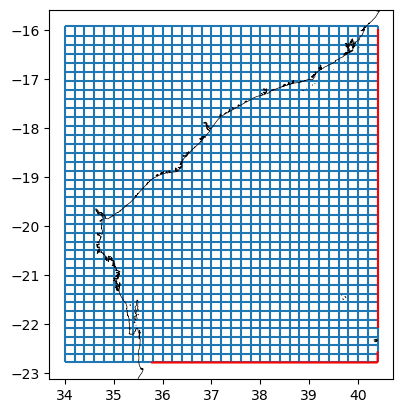

In [10]:
# plot basegrid and polyline
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
bnd_gdf_interp.plot(ax=ax, edgecolor='r')
# ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


In [11]:
# connect to a coarse version of the GEBCO_2022 dataset on OPeNDAP
# alternatively download your own full resolution cutout from https://download.gebco.net (use a buffer of e.g. 1 degree)
#file_nc_bathy = "https://opendap.deltares.nl/thredds/dodsC/opendap/deltares/Delft3D/netcdf_example_files/GEBCO_2022/GEBCO_2022_coarsefac08.nc"

if 'gebco2020' in model_name:
    file_bathy = r'p:\metocean-data\open\GEBCO\2020\GEBCO_2020.nc'
    data_bathy = xr.open_dataset(file_bathy).elevation
    data_bathy_sel = data_bathy.sel(lon=slice(lon_min-1, lon_max+1), lat=slice(lat_min-1, lat_max+1),drop=True)
elif 'gebco2023' in model_name:
    file_nc_bathy_sel = r'p:\11210471-001-compass\02_Models\Delft3DFM\mozambique_model\boundary_conditions\GEBCO_MZB\gebco_2023_n-8.0_s-29.0_w31.5_e48.5.nc'
    data_bathy_sel = xr.open_dataset(file_nc_bathy_sel).elevation

data_bathy_sel.load()

# alternatively you can connect to ETOPO 30s, for which there is also a 15s (15 arcseconds) resolution dataset available
# file_nc_bathy = "https://www.ngdc.noaa.gov/thredds/dodsC/global/ETOPO2022/30s/30s_surface_elev_netcdf/ETOPO_2022_v1_30s_N90W180_surface.nc"
# data_bathy = xr.open_dataset(file_nc_bathy).z

# subset to area of interest
#data_bathy_sel = data_bathy.sel(lon=slice(lon_min-1, lon_max+1), lat=slice(lat_min-1, lat_max+1))


<xarray.DataArray 'elevation' (lat: 5040, lon: 4080)> Size: 41MB
array([[   97,    90,    92, ..., -2643, -2635, -2634],
       [  115,   103,   101, ..., -2633, -2631, -2631],
       [  126,   130,   132, ..., -2630, -2629, -2630],
       ...,
       [ 1816,  1830,  1846, ..., -4558, -4553, -4546],
       [ 1808,  1819,  1836, ..., -4562, -4558, -4551],
       [ 1806,  1816,  1837, ..., -4568, -4563, -4557]], dtype=int16)
Coordinates:
  * lat      (lat) float64 40kB -29.0 -28.99 -28.99 ... -8.01 -8.006 -8.002
  * lon      (lon) float64 33kB 31.5 31.51 31.51 31.51 ... 48.49 48.49 48.5
Attributes:
    standard_name:       height_above_mean_sea_level
    long_name:           Elevation relative to sea level
    units:               m
    grid_mapping:        crs
    sdn_parameter_urn:   SDN:P01::ALATZZ01
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06::ULAA
    sdn_uom_name:        Metres

>> reading coastlines: 3.71 sec


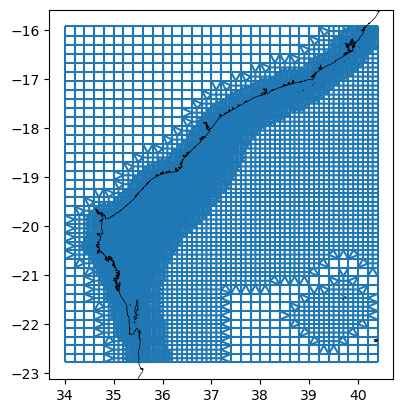

In [12]:
# refine grid
dfmt.refine_basegrid(mk=mk_object, data_bathy_sel=data_bathy_sel, min_edge_size=min_edge_size)

# plot
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
# ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


In [13]:
# remove land with GSHHS coastlines
dfmt.meshkernel_delete_withcoastlines(mk=mk_object,res='i',min_area=50,crs=crs)

>> reading coastlines: 0.95 sec


>> reading coastlines: 0.72 sec


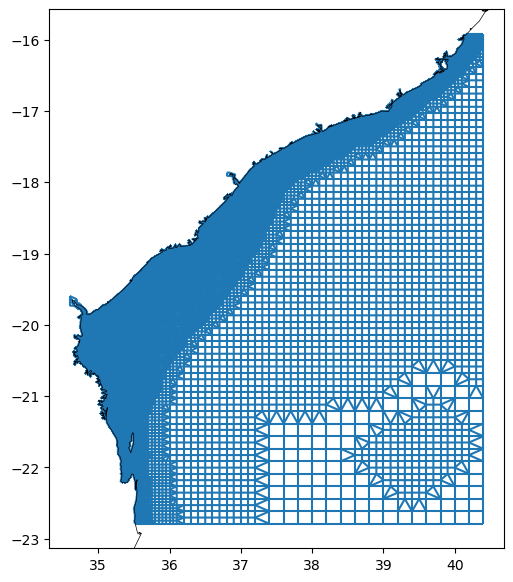

In [14]:
# plot
fig, ax = plt.subplots(figsize=(12,7))
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
# ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax,res='i',min_area=50,crs=crs)
#ax.set_xlim(46, 46.75)
#ax.set_ylim(-16.25,-15.50)

In [34]:
# Check orthogonality
#mk_object.mesh2d_get_orthogonality().values.max()

In [16]:
# derive illegalcells geodataframe
illegalcells_gdf = dfmt.meshkernel_get_illegalcells(mk=mk_object)


In [17]:
# create and add drypointsfile if there are any cells generated that will result in high orthogonality
if len(illegalcells_gdf) > 0:
    illegalcells_polyfile = dfmt.geodataframe_to_PolyFile(illegalcells_gdf)
    illegalcells_polyfile.save(os.path.join(dir_output_run,"illegalcells.pol"))

>> reading coastlines: 3.13 sec


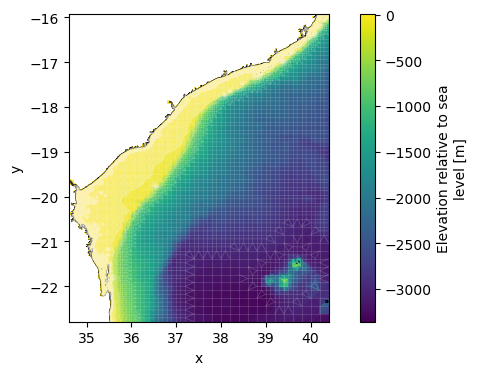

In [18]:
# convert to xugrid
xu_grid_uds = dfmt.meshkernel_to_UgridDataset(mk=mk_object, crs=crs)

# interpolate bathymetry onto the grid
data_bathy_interp = data_bathy_sel.interp(lon=xu_grid_uds.obj.mesh2d_node_x, lat=xu_grid_uds.obj.mesh2d_node_y)
xu_grid_uds['mesh2d_node_z'] = data_bathy_interp.clip(max=10)

# plot bathymetry and grid
fig, ax = plt.subplots(figsize=(8,4))
xu_grid_uds.mesh2d_node_z.ugrid.plot(ax=ax,center=False)
xu_grid_uds.grid.plot(ax=ax,linewidth=0.5,color='white',alpha=0.2)
# ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)

# write xugrid grid to netcdf
netfile = os.path.join(dir_output_run, f'{model_name}_net.nc')
xu_grid_uds.ugrid.to_netcdf(netfile)


## 4. Generate boundary conditions from tidal model (new *.ext file)
To simulate something useful we need boundary conditions for the model. These boundary conditions are forced via the new *.ext file. We initialize a [HYDROLIB-core](https://github.com/Deltares/HYDROLIB-core) `dflowfm.ExtModel` instance and append boundaries to it.

We start with the interpolation of tidal components from a global database. If you are working outside of the Deltares network, only the `*_opendap` sources will be available. The components of the chosen tidal model are interpolated to the points of the `dflowfm.PolyFile` we generated in the previous step and converted to a [HYDROLIB-core](https://github.com/Deltares/HYDROLIB-core) `dflowfm.ForcingModel` (*.bc file). The resulting tidal boundary condition has a set of tidal components with amplitudes and phases for each boundary point.


In [19]:
# generate new format external forcings file (.ext): initial and open boundary condition
ext_file_new = os.path.join(dir_output_run, f'{model_name}_new.ext')
ext_new = hcdfm.ExtModel()

In [22]:
# interpolate tidal components to boundary conditions file (.bc)
dfmt.interpolate_tide_to_bc(ext_new=ext_new, tidemodel=tidemodel, file_pli=poly_file, component_list=None)

> interp mfdataset to all PolyFile points (lat/lon coordinates)
> actual extraction of data from netcdf with .load() (for 368 plipoints at once, this might take a while)
>>time passed: 82.34 sec
Converting 368 plipoints to hcdfm.ForcingModel(): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216

In [23]:
#save new ext file
ext_new.save(filepath=ext_file_new) # ,path_style=path_style)

## 5. Define meteo forcing (old *.ext file)
We will supply more boundary conditions to the model via the old *.ext file. We initialize a [HYDROLIB-core](https://github.com/Deltares/HYDROLIB-core) `dflowfm.ExtOldModel` instance and append boundaries to it. These boundaries are [HYDROLIB-core](https://github.com/Deltares/HYDROLIB-core) `dflowfm.ExtOldForcing` instances.

Meteo forcing is define using one of the sources below:
 - ERA5 meteo data - retrieved from the Copernicus [Climate Data Store](https://cds.climate.copernicus.eu/user/register). The netcdf files are merged in time and written to the netcdf format expected by D-Flow FM.
 - Tropical cyclone meteo forcing defined using a spiderweb (spw) file

In [24]:
# generate old format external forcings file (.ext): spatial data
ext_file_old = os.path.join(dir_output_run, f'{model_name}_old.ext')

In [25]:
ext_old = hcdfm.ExtOldModel()

if meteo_type=='ERA5': # ERA5 - download spatial fields of air pressure, wind speeds and Charnock coefficient
    dir_output_data_era5 = os.path.join(dir_output_bc,'meteo', 'ERA5')
    os.makedirs(dir_output_data_era5, exist_ok=True)
        
    varlist_list = [['msl','u10n','v10n','chnk']]

    for varlist in varlist_list:
        for varkey in varlist:
            dfmt.download_ERA5(varkey, 
                            longitude_min=lon_min, longitude_max=lon_max, latitude_min=lat_min, latitude_max=lat_max,
                            date_min=date_min, date_max=date_max,
                            dir_output=dir_output_data_era5, overwrite=overwrite)

    # ERA5 meteo - convert to netCDF for usage in Delft3D FM
    ext_old = dfmt.preprocess_merge_meteofiles_era5(ext_old=ext_old,
                                                    varkey_list=varlist_list,
                                                    dir_data=dir_output_data_era5,
                                                    dir_output=dir_output_run,
                                                    time_slice=slice(date_min, date_max))
if spw:
    spw_file = spw_name + '.spw'
    shutil.copyfile(spw_file_origin, os.path.join(dir_output_run,spw_file))

    uniformwind_filename = 'uniformwind0.wnd'
    shutil.copyfile(os.path.join(dir_output_bc,'meteo',uniformwind_filename),os.path.join(dir_output_run,uniformwind_filename))

    forcing_uniformwind = hcdfm.ExtOldForcing(quantity='windxy',
                                        filename=uniformwind_filename,
                                        filetype=hcdfm.ExtOldFileType.TimeSeries, 
                                        method=hcdfm.ExtOldMethod.PassThrough, 
                                        operand=hcdfm.Operand.override)
    ext_old.forcing.append(forcing_uniformwind)
    
    forcing_spw = hcdfm.ExtOldForcing(quantity='airpressure_windx_windy',
                                        filename=spw_file,
                                        filetype=hcdfm.ExtOldFileType.SpiderWebData, 
                                        method=hcdfm.ExtOldMethod.PassThrough, 
                                        operand=hcdfm.Operand.add)
    ext_old.forcing.append(forcing_spw)

ext_old.save(filepath=ext_file_old) # , path_style=path_style)


In [26]:
if meteo_type=='ERA5':
    # plot converted ERA5 data
    file_era5 = os.path.join(dir_output_bc,'meteo','ERA5','*.nc')
    ds_era5 = xr.open_mfdataset(file_era5)
    ds_era5

    # plot
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    ds_era5.u10n.isel(time=0).plot(ax=ax1)
    dfmt.plot_coastlines(ax=ax1, crs=crs)
    ds_era5.v10n.isel(time=0).plot(ax=ax2)
    dfmt.plot_coastlines(ax=ax2, crs=crs)
    fig.tight_layout()


## 6. Generate obsfile
The D-Flow FM model wil have mapoutput and hisoutput. A file with coordinates of obs stations will be generated.

In [27]:
# using example points from the IHE course
tmp = pd.read_table(r'n:\Deltabox\Bulletin\goede_rl\IHE_course\SFINCS\01_surge\01_basemodel\sfincs.obs',sep="\s+",names=['x', 'y', 'names'])

from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:32736", "EPSG:4326",always_xy=True)
obs_all_pd = tmp
obs_all_pd['x'],obs_all_pd['y']=transformer.transform(tmp['x'],tmp['y'])

Option for generating random obs points:

In [ ]:
# # generate obspoints on all grid faces
# xpts = xu_grid_uds.grid.face_x
# ypts = xu_grid_uds.grid.face_y
# npts = [f'x{x:.2f}_y{y:.2f}'.replace('.','p') for x,y in zip(xpts,ypts)]
# obs_pd = pd.DataFrame(dict(x=xpts,y=ypts,names=npts))

# # subselect n arbitary obspoints and plot
# n = 100
# ipts = np.random.randint(0, len(obs_pd), n)
# obs_pd = obs_pd.iloc[ipts]

# # add extra output points
# obs_extra = [{'x':35.383335,'y':-23.866667, 'names':'INHAMBANE IHO'},
#              {'x':35.433334,'y': -21.650000, 'names':'BAZARUTO IHO' },
#              {'x':35.066666,'y':-21.116667, 'names':'BARTOLOMEU DIAS IHO'},
#              {'x':34.883335,'y':-20.616667, 'names':'CHILOANE IHO'},
#              {'x':34.833332,'y':-19.816668, 'names':'BEIRA IHO'},
#              {'x':36.450001,'y':-18.566668 , 'names':'CHINDE IHO'},
#              {'x':36.966667,'y':-18.000000, 'names':'QUELIMANE IHO'},
#              {'x':38.133335,'y': -17.266666, 'names':'PEBANE IHO'},
#              {'x':35.016842,'y':-19.929055, 'names':'BeiraOff'},
#              {'x':34.905008,'y':-19.799669, 'names':'Airport'},
#              {'x':45.258301,'y':-12.78333, 'names':'mayotte_obs'}]
# obs_extra_df = pd.DataFrame(obs_extra)

# # merge the two dataframes into a list of obs points
# obs_all_pd = pd.concat([obs_extra_df,obs_pd])

# print(obs_all_pd)


>> reading coastlines: 3.93 sec


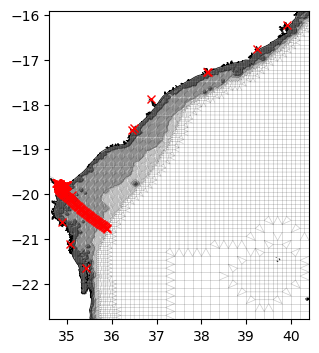

In [28]:
# plot obs points
fig, ax = plt.subplots(figsize=(8,4))
xu_grid_uds.grid.plot(ax=ax,linewidth=0.5,color='k',alpha=0.2)
ax.plot(obs_all_pd['x'],obs_all_pd['y'],'rx')
dfmt.plot_coastlines(ax=ax, crs=crs)

# save obsfile
file_obs = os.path.join(dir_output_run, f'{model_name}_obs.xyn')
obs_all_pd.to_csv(file_obs, sep=' ', header=False, index=False, float_format='%.6f')

## 7. Generate mdu file
In order for the model to run, we need a model definition file. In case of D-Flow FM this is a *.mdu file, represented by the [HYDROLIB-core](https://github.com/Deltares/HYDROLIB-core) `dflowfm.FMModel`. This is initialized and many of the files we generated above (network, extfiles, obsfile) are linked here. You can visualize the resulting model tree with `mdu.show_tree()`. We can also adjust any of the parameters in the *.mdu file by setting them here.

In [29]:
# initialize mdu file and update settings
mdu_file = os.path.join(dir_output_run, f'{model_name}.mdu')

#mdu = hcdfm.FMModel()

# use mdu file from GTSM
base_mdu = os.path.join(dir_output_main,'general','base_model_settings.mdu')
mdu = hcdfm.FMModel(base_mdu)

if len(illegalcells_gdf) > 0:
    mdu.geometry.drypointsfile = [illegalcells_polyfile]

# add the grid (_net.nc, network file)
mdu.geometry.netfile = netfile

# add the external forcing files (.ext)
mdu.external_forcing.extforcefile = ext_file_old
mdu.external_forcing.extforcefilenew = ext_file_new

# Define drag coefficient 
mdu.wind.icdtyp = 3 
mdu.wind.cdbreakpoints = [0.001, 0.003, 0.0015]
mdu.wind.windspeedbreakpoints = [0, 25, 50]

# update time settings
mdu.time.refdate = pd.Timestamp(ref_date).strftime('%Y%m%d')
mdu.time.tunit = 'S'
mdu.time.dtmax = 30
mdu.time.startdatetime = pd.Timestamp(date_min).strftime('%Y%m%d%H%M%S')
mdu.time.stopdatetime = pd.Timestamp(date_max).strftime('%Y%m%d%H%M%S')
mdu.time.autotimestep = 3

# update output settings
mdu.output.obsfile = file_obs
mdu.output.hisinterval = [600] #s
mdu.output.mapinterval = [3600]
mdu.output.rstinterval = [0]
mdu.output.statsinterval = [3600]

# save .mdu file
mdu.save(mdu_file) # ,path_style=path_style)

# make all paths relative (might be properly implemented in https://github.com/Deltares/HYDROLIB-core/issues/532)
dfmt.make_paths_relative(mdu_file)

## 8. Generate DIMR and bat file
In order to run the model via DIMR we need a `dimr_config.xml` file. If you are running this notebook on a Windows platform, a *.bat file will also be created with which you can run the model directly. In order for this to work you need to update the `dimrset_folder` to the path where the `x64` and or `lnx64` folder is located. Provide `None` if you have no D-Flow FM executable available on your system.


In [30]:
nproc = 1 # number of processes
dimrset_folder = r"p:\d-hydro\dimrset\weekly\2.25.17.78708" # alternatively r"c:\Program Files\Deltares\Delft3D FM Suite 2023.03 HMWQ\plugins\DeltaShell.Dimr\kernels" #alternatively r"p:\d-hydro\dimrset\weekly\2.25.17.78708"
dfmt.create_model_exec_files(file_mdu=mdu_file, nproc=nproc, dimrset_folder=dimrset_folder)


writing dimr_config.xml
writing run_parallel.bat


## 9. Visualize model tree

In [31]:
# visualize the model tree, show_tree is available for all HYDROLIB-core model components
mdu_obj = hcdfm.FMModel(mdu_file)
mdu_obj.show_tree()

  p:\11210471-001-compass\02_Models\Delft3DFM\mozambique_model\computations\mozambique_spw_Idai_areaBeira_500m_gebco2023\mozambique_spw_Idai_areaBeira_500m_gebco2023.mdu
    Geometry
     ∟ mozambique_spw_Idai_areaBeira_500m_gebco2023_net.nc
     ∟ illegalcells.pol
    ExternalForcing
     ∟ mozambique_spw_Idai_areaBeira_500m_gebco2023_old.ext
       ∟ ExtOldForcing
         ∟ uniformwind0.wnd
       ∟ ExtOldForcing
         ∟ cyclone_Idai.spw
     ∟ mozambique_spw_Idai_areaBeira_500m_gebco2023_new.ext
       ∟ Boundary
         ∟ L1.pli
         ∟ tide_FES2014.bc
       ∟ Boundary
         ∟ L2.pli
         ∟ tide_FES2014.bc
    Output
     ∟ mozambique_spw_Idai_areaBeira_500m_gebco2023_obs.xyn


# 